# Convolutional Neural Network (CNN) for Plant Disease Classification

This notebook trains (or loads) a CNN model to classify plant leaf images into disease categories using the **PlantVillage** dataset.

**Workflow**
1. Import libraries and set hyperparameters  
2. Load and explore the dataset  
3. Split into train/validation/test  
4. Build, compile, and train the CNN (or reload a saved model)  
5. Evaluate on the test set (accuracy, classification report, confusion matrix)  
6. Do basic error analysis


## 1. Imports
We import the main libraries used in this notebook: TensorFlow/Keras for the CNN, NumPy for arrays, and Matplotlib for plots.


In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt


## 2. Basic configuration
Set the key hyperparameters: image size, batch size, number of channels (RGB), and training epochs.


In [9]:
image_size = (256) # 256x256 pixels
batch_size = 16 # images per batch
channels = 3 # RGB
epochs = 20 # number of training epochs


## 3. Load the dataset and exploratory data analysis 
Loads images from your `PlantVillage` directory. Each subfolder name becomes a class label automatically.


In [10]:
# Load images from a folder structure into a tf.data.Dataset.
# Expected folder layout:
#   ../data/raw/PlantVillage/
#       class_1/  (images...)
#       class_2/  (images...)
#       ...
# Each subfolder name becomes the class label automatically.
dataset = tf.keras.utils.image_dataset_from_directory(
    directory = "../data/raw/PlantVillage",     # root folder containing one subfolder per class
    image_size = (image_size, image_size),      # resize every image to this fixed size (H, W)
    batch_size = batch_size                     # how many images per batch returned by the dataset
)

# Result:
# - dataset yields batches of (images, labels)
# - images shape: (batch_size, image_size, image_size, 3)
# - labels are integer class IDs (e.g., 0..num_classes-1)


Found 46955 files belonging to 10 classes.


### Class names
Keras assigns an integer label to each class based on folder order. `class_names` stores the mapping.


In [11]:
# Get the list of class (label) names inferred from the subfolder names
# inside the PlantVillage directory.
# Example: ["Apple___Black_rot", "Apple___healthy", ...]
class_names = dataset.class_names

# Display / print the class names (in notebooks, the last line shows the value)
class_names



['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_Mold',
 'Mosaic_virus',
 'Septoria_leaf_spot',
 'Spider_mites_Two_spotted_spider_mite',
 'Target_Spot',
 'YellowLeaf__Curl_Virus']

### Inspect one batch
Checks the tensor shapes coming from the dataset and prints the label ids in that batch.


In [12]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)   # image batch shape
    print(label_batch.numpy()) # labels as numpy


(16, 256, 256, 3)
[2 0 7 7 4 7 6 9 1 2 3 8 8 7 7 7]


### Inspect one image shape
Shows the shape of a single image tensor (height, width, channels).


In [13]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)


(256, 256, 3)


### Inspect raw pixel values
Prints raw pixel values for one image (before rescaling).


In [14]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())  # pixel values (array) of the first image in the batch



[[[150. 154. 155.]
  [150. 154. 155.]
  [150. 154. 155.]
  ...
  [137. 142. 145.]
  [136. 141. 144.]
  [136. 141. 144.]]

 [[149. 153. 154.]
  [149. 153. 154.]
  [150. 154. 155.]
  ...
  [138. 143. 146.]
  [138. 143. 146.]
  [139. 144. 147.]]

 [[149. 153. 154.]
  [149. 153. 154.]
  [150. 154. 155.]
  ...
  [138. 143. 146.]
  [140. 145. 148.]
  [141. 146. 149.]]

 ...

 [[135. 136. 128.]
  [133. 134. 126.]
  [129. 130. 122.]
  ...
  [103. 105.  94.]
  [101. 103.  92.]
  [ 99. 101.  90.]]

 [[121. 122. 114.]
  [122. 123. 115.]
  [123. 124. 116.]
  ...
  [100. 102.  91.]
  [ 99. 101.  90.]
  [ 97.  99.  88.]]

 [[119. 120. 112.]
  [121. 122. 114.]
  [125. 126. 118.]
  ...
  [ 97.  99.  88.]
  [ 96.  98.  87.]
  [ 95.  97.  86.]]]


### Visualize a sample image
Displays one example image from the dataset.


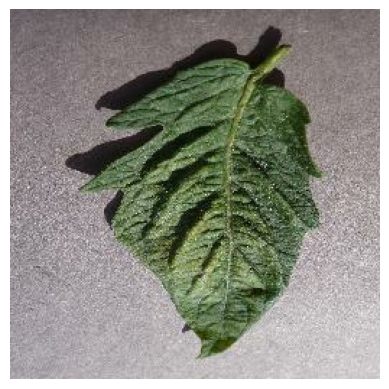

In [15]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))  # show first image (convert to uint8 for display)
    plt.axis("off")                                      # hide axes


### Label id → class name mapping
Prints the numeric label id for each class. **Note:** this cell previously contained extra code; it has been cleaned to only show the mapping.


In [16]:
for label_id, class_name in enumerate(dataset.class_names):
    print(f"{label_id} : {class_name}")  # print: class_index : class_name



0 : Bacterial_spot
1 : Early_blight
2 : Healthy
3 : Late_blight
4 : Leaf_Mold
5 : Mosaic_virus
6 : Septoria_leaf_spot
7 : Spider_mites_Two_spotted_spider_mite
8 : Target_Spot
9 : YellowLeaf__Curl_Virus


### Collect one sample per class
Unbatches the dataset and stores the first image seen for each class. This is useful for later visualization.


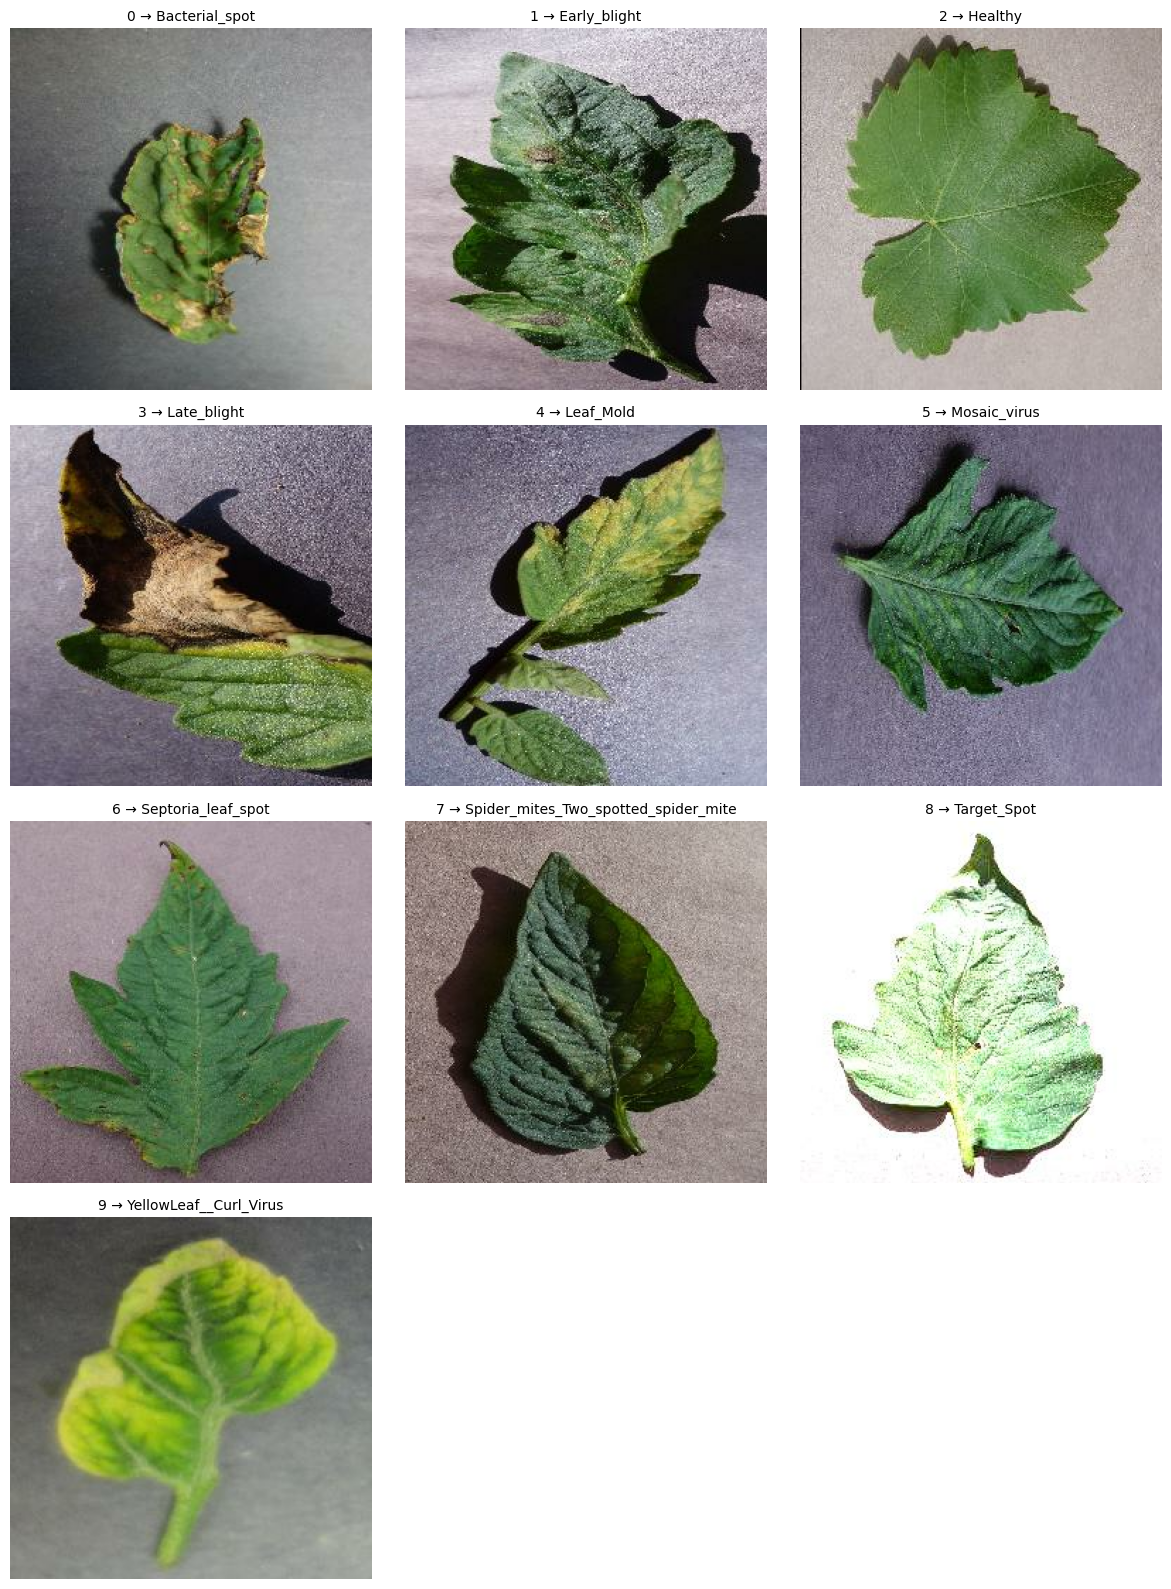

In [17]:
import math

class_names = dataset.class_names                 # class names (from folder names)
num_classes = len(class_names)                    # number of classes

samples = {}                                      # store 1 sample image per class

for img, label in dataset.unbatch():              # iterate image-by-image (not in batches)
    label_id = int(label.numpy())                 # tensor -> int
    if label_id not in samples:
        samples[label_id] = img                   # keep the first image for this class
    if len(samples) == num_classes:
        break                                     # stop after collecting all classes

cols = 3
rows = math.ceil(num_classes / cols)              # rows needed for the grid

plt.figure(figsize=(4*cols, 4*rows))
for i, label_id in enumerate(sorted(samples.keys())):
    ax = plt.subplot(rows, cols, i + 1)           # position in the grid

    img = samples[label_id].numpy().astype("uint8")  # convert to display format
    plt.imshow(img)                               # show image
    plt.title(f"{label_id} → {class_names[label_id]}", fontsize=10)  # label + name
    plt.axis("off")                               # hide axes

plt.tight_layout()                                # nicer spacing
plt.show()                                        # render the figure


## 4. Train/validation/test split
Splits a `tf.data.Dataset` into train/val/test using `take()` and `skip()`. This assumes the dataset has a known length.


In [18]:
def spliting_the_data(ds, train_split=0.80, val_split=0.10, test_split=0.10, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)                          # total number of batches/elements in ds

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) # shuffle before splitting

    train_size = int(train_split * ds_size)    # number of items for train
    val_size   = int(val_split * ds_size)      # number of items for val

    train_ds = ds.take(train_size)             # first part -> train
    val_ds   = ds.skip(train_size).take(val_size)  # next part -> val
    test_ds  = ds.skip(train_size).skip(val_size)  # remaining -> test

    return train_ds, val_ds, test_ds           # return the 3 datasets


### Create the splits
Runs the split function and produces `train_ds`, `val_ds`, and `test_ds`.


In [19]:
train_ds, val_ds, test_ds = spliting_the_data(dataset)  # split dataset into train/val/test



### Check split sizes
Shows the number of batches in each split (may be `unknown` in some pipelines).


In [20]:
len(train_ds), len(val_ds), len(test_ds)  # number of batches/items in each split

(2348, 293, 294)

## 5. Preprocessing and data augmentation
- **Resizing** ensures all images have the same shape.
- **Rescaling** normalizes pixels to `[0, 1]`.
- **Augmentation** creates random flips/rotations to improve generalization.


In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),   # resize to fixed size
    layers.Rescaling(1.0/255)                  # normalize pixels to [0, 1]
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),  # random flips
    layers.RandomRotation(0.2)                     # random rotation
])

## 6. Build the CNN model


### Model architecture
Defines a Sequential CNN: preprocessing → conv/pool blocks → flatten → dense → softmax. If you want a deeper network, add more conv/pool blocks.


In [22]:
input_shape = (image_size, image_size, channels)

class_names = dataset.class_names
n_classes = len(class_names)

model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),

    # optional but recommended for your "no json" goal:
    ClassNamesLayer(class_names=class_names, name="class_names"),
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

### Compile the model
Sets the optimizer, loss function, and metrics. `SparseCategoricalCrossentropy` is correct when labels are integer-encoded.


In [23]:
model.compile(
    optimizer='adam',   # training algorithm (Adam optimizer)
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # loss for integer labels + softmax output
    metrics=['accuracy']  # track accuracy during training/eval
)

model.summary()  # show model architecture + parameters




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                

### Early stopping 

In [24]:
import tensorflow as tf

@tf.keras.utils.register_keras_serializable(package="meta")
class ClassNamesLayer(tf.keras.layers.Layer):
    def __init__(self, class_names=None, **kwargs):
        # Remove trainable if it comes from saved config to avoid duplicates
        kwargs.pop("trainable", None)
        super().__init__(**kwargs)

        self.class_names = list(class_names) if class_names is not None else []
        self.trainable = False  # force non-trainable

    def call(self, inputs):
        return inputs  # identity

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"class_names": self.class_names})
        return cfg

    @classmethod
    def from_config(cls, config):
        return cls(**config)


### GPU setup (optional)
Enables memory growth so TensorFlow doesn't reserve all GPU memory at once.


In [25]:
import tensorflow as tf  # TensorFlow library

gpus = tf.config.list_physical_devices('GPU')          # list available GPUs
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # use GPU memory as needed (avoid full pre-allocation)

print("GPUs:", gpus)                                   # show detected GPUs



GPUs: []


### Train or load a saved model
Use `TRAIN = True` to train and save, or `TRAIN = False` to load the saved model from disk. This cell also prints TensorFlow/Keras versions and some file info.


In [5]:
import os                                   # file/path utilities
from datetime import datetime                # (not used here, can remove)
import tensorflow as tf                      # TensorFlow

MODEL_PATH = "../models/image_classification_model.keras"  # where to save/load the model
TRAIN = False                                # True = train + save, False = load existing model

if TRAIN:
    print("Training model...")
    model_history = model.fit(
        train_ds,                            # training dataset
        validation_data=val_ds,              # validation dataset
        epochs=epochs,                       # number of epochs
        callbacks=callbacks,                 # callbacks (early stop, checkpoint, etc.)
        verbose=1                            # show training progress
    )
    model.save(MODEL_PATH)                   # save trained model
    print("Saved model to:", MODEL_PATH)

else:
    if os.path.exists(MODEL_PATH):           # check model file exists
        print("Loading saved model...")
        model = tf.keras.models.load_model(MODEL_PATH)  # load saved model
        print("Loaded model from:", MODEL_PATH)
    else:
        raise FileNotFoundError(             # error if model file is missing
            f"Model not found at: {MODEL_PATH}\n"
            "Either fix the path or set TRAIN=True to train and save the model."
        )


Loading saved model...
Loaded model from: ../models/image_classification_model.keras


### Embed Class Names Inside the Saved Model 

This code creates a tiny custom Keras layer that does nothing to the data, but it stores the class labels (folder names) inside the model file when it is saved.
That way, when the model is loaded (e.g., in Streamlit), the class names could be directly read from the model, and they will automatically update whenever the model is retrain withed with new/changed classes.

In [6]:
import os
import shutil
@tf.keras.utils.register_keras_serializable(package="meta")
class ClassNamesLayer(tf.keras.layers.Layer):
    def __init__(self, class_names=None, **kwargs):
        # Prevent "trainable passed twice" issues on load
        kwargs.pop("trainable", None)
        super().__init__(**kwargs)
        self.class_names = list(class_names) if class_names is not None else []
        self.trainable = False

    def call(self, inputs):
        return inputs  # identity

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"class_names": self.class_names})
        return cfg

    @classmethod
    def from_config(cls, config):
        return cls(**config)


OLD_MODEL_PATH = "../models/image_classification_model.keras"
NEW_MODEL_PATH = "../models/image_classification_model_with_names.keras"

# ✅ Option 1: use the ORIGINAL dataset object (NOT train_ds / val_ds / test_ds)
class_names = list(dataset.class_names)   # <- this exists in your notebook

# (optional) backup the old model file
if os.path.exists(OLD_MODEL_PATH):
    backup = OLD_MODEL_PATH.replace(".keras", "_backup.keras")
    shutil.copy2(OLD_MODEL_PATH, backup)
    print("Backup saved to:", backup)

# robust load (works across versions)
try:
    base_model = tf.keras.models.load_model(
        OLD_MODEL_PATH,
        custom_objects={"ClassNamesLayer": ClassNamesLayer},
        compile=False,
        safe_mode=False,
    )
except TypeError:
    base_model = tf.keras.models.load_model(
        OLD_MODEL_PATH,
        custom_objects={"ClassNamesLayer": ClassNamesLayer},
        compile=False,
    )

# wrap model with metadata layer
model_with_names = tf.keras.Sequential(
    [ClassNamesLayer(class_names=class_names, name="class_names"), base_model],
    name="model_with_classnames"
)

os.makedirs(os.path.dirname(NEW_MODEL_PATH), exist_ok=True)
model_with_names.save(NEW_MODEL_PATH)
print("✅ Saved model with embedded class names to:", NEW_MODEL_PATH)
print("Example classes:", class_names[:5])


Backup saved to: ../models/image_classification_model_backup.keras
✅ Saved model with embedded class names to: ../models/image_classification_model_with_names.keras
Example classes: ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Leaf_Mold']


d:\data_science_dir\image_clasification_model\.venv\Lib\site-packages\keras\src\saving\saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


### Testing and model evaluation
Returns test loss and test accuracy.


In [43]:
if "scores" not in globals():
    model.evaluate(test_ds, verbose=1)
else:
    print("✅ Using cached scores (not re-evaluating).")

print("metrics:", model.metrics_names)


294/294 [==============================] - 294s 220ms/step - loss: 0.1620 - accuracy: 0.9485
metrics: ['loss', 'accuracy']


### Predict labels on the test set
Collects true labels and predicted labels so we can build a classification report and confusion matrix.


In [22]:
y_true_list = []                      # store true labels from all batches
y_pred_list = []                      # store predicted labels from all batches

for x_batch, y_batch in test_ds:      # loop over test batches (images, labels)
    probs = model.predict(x_batch, verbose=0)   # predicted class probabilities
    y_pred_batch = np.argmax(probs, axis=1)     # pick class with highest probability

    y_true_batch = y_batch.numpy()    # true labels as numpy

    y_true_list.append(y_true_batch)  # collect true labels
    y_pred_list.append(y_pred_batch)  # collect predicted labels

y_true = np.concatenate(y_true_list)  # merge all true labels into one array
y_pred = np.concatenate(y_pred_list)  # merge all predictions into one array

print("Manual test accuracy:", (y_true == y_pred).mean())  # compare with model.evaluate accuracy


Manual test accuracy: 0.954719387755102


### Confusion matrix plot
Shows where the model confuses one class for another.


<Figure size 1000x800 with 0 Axes>

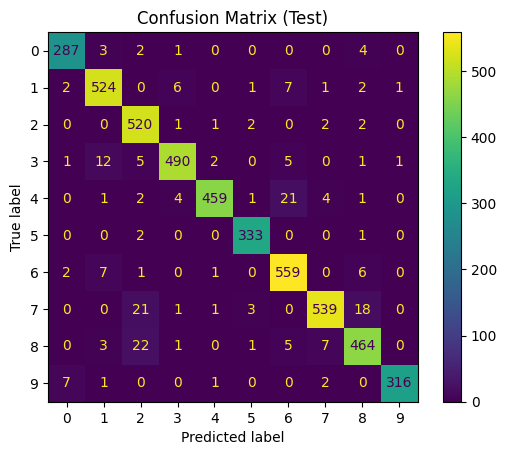

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # confusion matrix tools

cm = confusion_matrix(y_true, y_pred)      # build confusion matrix from true vs predicted labels

plt.figure(figsize=(10, 8))               # set figure size
disp = ConfusionMatrixDisplay(confusion_matrix=cm)  # wrap matrix for plotting
disp.plot(values_format="d")              # plot counts as integers
plt.title("Confusion Matrix (Test)")      # title
plt.show()                                # display plot


### Classification report
Precision/recall/F1-score per class, plus macro and weighted averages.


In [ ]:
from sklearn.metrics import classification_report
cm = confusion_matrix(y_true, y_pred)  # compute confusion matrix

print(classification_report(
    y_true, y_pred,                    # true labels vs predicted labels
    target_names=class_names,          # show class names instead of numbers
    digits=4                           # print metrics with 4 decimals
))



                                      precision    recall  f1-score   support

                      Bacterial_spot     0.9599    0.9663    0.9631       297
                        Early_blight     0.9510    0.9632    0.9571       544
                             Healthy     0.9043    0.9848    0.9429       528
                         Late_blight     0.9722    0.9478    0.9598       517
                           Leaf_Mold     0.9871    0.9310    0.9582       493
                        Mosaic_virus     0.9765    0.9911    0.9838       336
                  Septoria_leaf_spot     0.9363    0.9705    0.9531       576
Spider_mites_Two_spotted_spider_mite     0.9712    0.9245    0.9473       583
                         Target_Spot     0.9299    0.9225    0.9261       503
              YellowLeaf__Curl_Virus     0.9937    0.9664    0.9798       327

                            accuracy                         0.9547      4704
                           macro avg     0.9582    0.9568    0

### Inspect wrong predictions
Collects a few misclassified examples so you can visually check what went wrong.


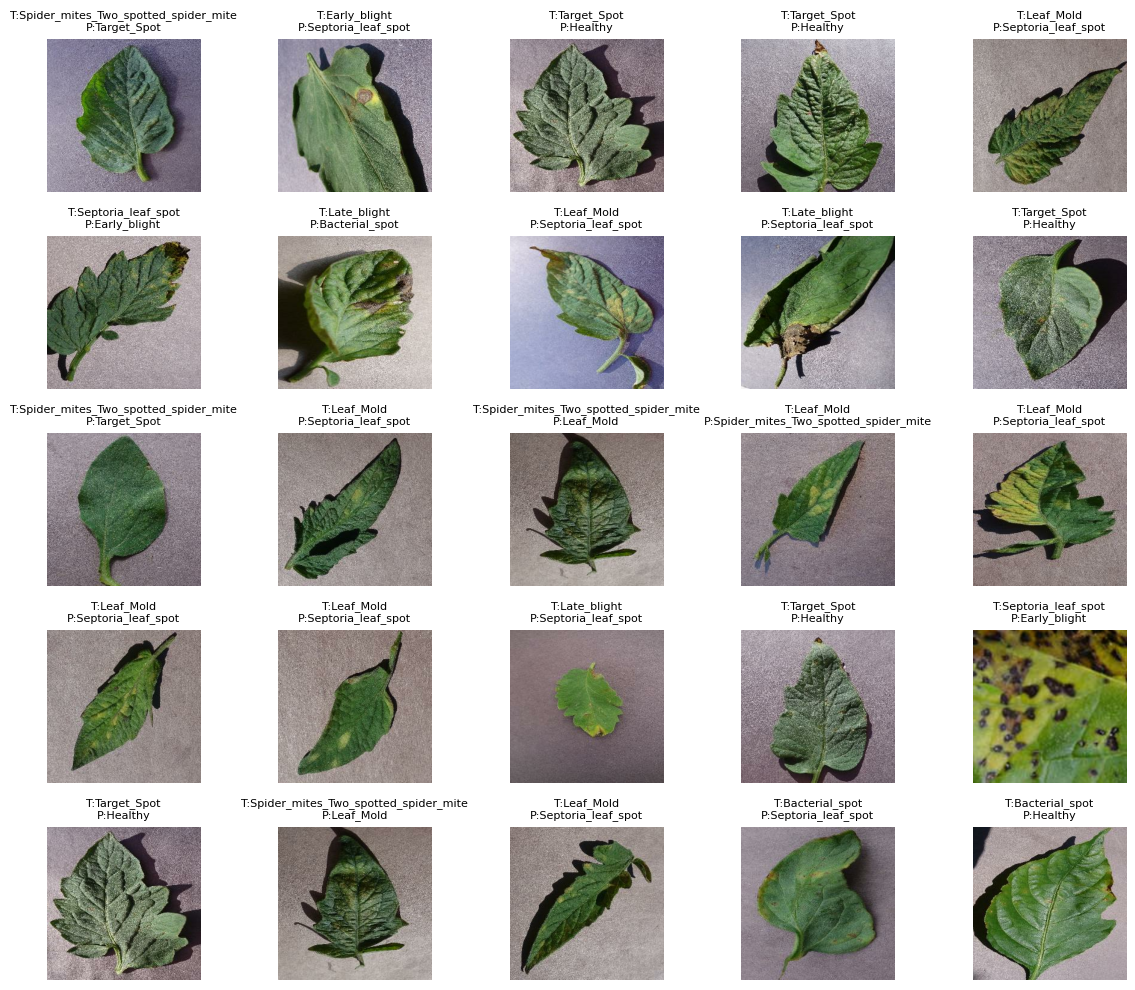

In [ ]:
import matplotlib.pyplot as plt   # plotting
import numpy as np                # arrays

wrong = []  # store (image, true_label, pred_label) for mistakes

for x_batch, y_batch in test_ds:                      # loop over test batches
    probs = model.predict(x_batch, verbose=0)         # predict probabilities
    pred = np.argmax(probs, axis=1)                   # predicted class ids

    if len(y_batch.shape) > 1 and y_batch.shape[-1] > 1:  # if labels are one-hot
        true = np.argmax(y_batch.numpy(), axis=1)          # convert to class ids
    else:
        true = y_batch.numpy().astype(int)                 # sparse labels -> int

    for i in range(len(true)):                             # check each item in batch
        if true[i] != pred[i]:
            wrong.append((x_batch[i].numpy().astype("uint8"), true[i], pred[i]))  # save mistake
    if len(wrong) >= 25:
        break                                              # stop after collecting 25 mistakes

plt.figure(figsize=(12, 10))                               # create figure
for i, (img, t, p) in enumerate(wrong[:25]):               # plot up to 25 wrong images
    plt.subplot(5, 5, i+1)
    plt.imshow(img)                                       # show image
    t_name = class_names[t] if "class_names" in globals() else str(t)  # true name
    p_name = class_names[p] if "class_names" in globals() else str(p)  # pred name
    plt.title(f"T:{t_name}\nP:{p_name}", fontsize=8)       # title (T=true, P=pred)
    plt.axis("off")                                       # hide axes
plt.tight_layout()                                        # spacing
plt.show()                                                # display


### Error analysis 

In [ ]:
import numpy as np  # arrays + numerical ops

pairs = []                          # store (count, true_class_name, predicted_class_name)
n = len(class_names)                # number of classes

for i in range(n):                  # loop over true class index
    for j in range(n):              # loop over predicted class index
        if i != j and cm[i, j] > 0: # keep only mistakes (off-diagonal) with count > 0
            pairs.append((cm[i, j], class_names[i], class_names[j]))  # save this confusion pair

for c, true_name, pred_name in sorted(pairs, reverse=True)[:15]:  # top 15 biggest confusions
    print(f"{c:>3}  True: {true_name:30s}  → Pred: {pred_name}")   # print nicely formatted


 22  True: Target_Spot                     → Pred: Healthy
 21  True: Spider_mites_Two_spotted_spider_mite  → Pred: Healthy
 21  True: Leaf_Mold                       → Pred: Septoria_leaf_spot
 18  True: Spider_mites_Two_spotted_spider_mite  → Pred: Target_Spot
 12  True: Late_blight                     → Pred: Early_blight
  7  True: YellowLeaf__Curl_Virus          → Pred: Bacterial_spot
  7  True: Target_Spot                     → Pred: Spider_mites_Two_spotted_spider_mite
  7  True: Septoria_leaf_spot              → Pred: Early_blight
  7  True: Early_blight                    → Pred: Septoria_leaf_spot
  6  True: Septoria_leaf_spot              → Pred: Target_Spot
  6  True: Early_blight                    → Pred: Late_blight
  5  True: Target_Spot                     → Pred: Septoria_leaf_spot
  5  True: Late_blight                     → Pred: Septoria_leaf_spot
  5  True: Late_blight                     → Pred: Healthy
  4  True: Leaf_Mold                       → Pred: Spider_mi

The main remaining errors are concentrated in a few visually similar categories—especially Spider_mites → Target_Spot (9) and Spider_mites → healthy (8), plus smaller mix-ups like Septoria_leaf_spot → Early_blight (5). This is reasonable because these classes can share similar “spotty” textures, and symptoms may be subtle or appear in early stages, making the visual cues harder even for humans.